In [0]:
!mkdir jena_climate
!cd jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2018-11-30 13:56:03--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.101.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.101.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.54MB/s    in 2.0s    

2018-11-30 13:56:06 (6.54 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [0]:
import os
f = open('jena_climate_2009_2016.csv')

data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
# print(lines)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [0]:
import numpy as np

float_data = np.zeros((len(lines), len(header) -1 ))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

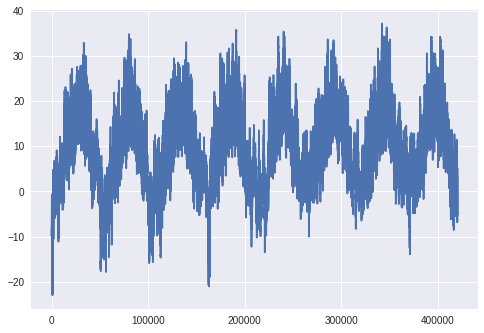

In [0]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

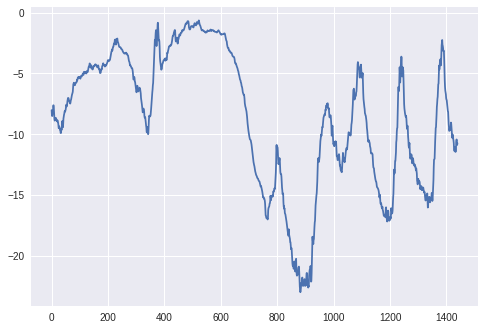

In [0]:
plt.plot(range(1440), temp[:1440])

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [0]:
val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [0]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
  
evaluate_naive_method()

0.2897359729905486


In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 17s 33ms/step - loss: 1.3754 - val_loss: 0.7636
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.4531 - val_loss: 0.3310
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2934 - val_loss: 0.3005
Epoch 4/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2663 - val_loss: 0.3348
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2513 - val_loss: 0.3267
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2416 - val_loss: 0.3146
Epoch 7/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2356 - val_loss: 0.3307
Epoch 8/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2289 - val_loss: 0.3220
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2244 - val_loss: 0.3372
Epoch 10/20
500/500 [==============================] - 14s 27ms/step - loss: 0.220

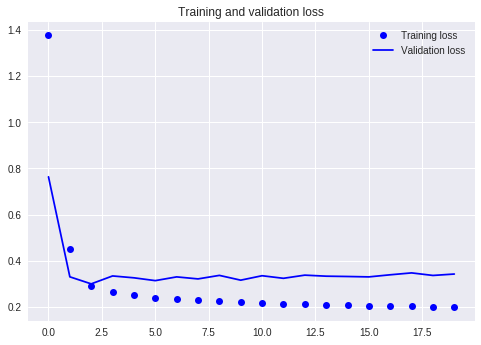

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 285s 570ms/step - loss: 0.2986 - val_loss: 0.2669
Epoch 2/20
500/500 [==============================] - 284s 568ms/step - loss: 0.2811 - val_loss: 0.2660
Epoch 3/20
500/500 [==============================] - 285s 569ms/step - loss: 0.2759 - val_loss: 0.2624
Epoch 4/20
500/500 [==============================] - 283s 565ms/step - loss: 0.2700 - val_loss: 0.2618
Epoch 5/20
500/500 [==============================] - 284s 568ms/step - loss: 0.2656 - val_loss: 0.2617
Epoch 6/20
500/500 [==============================] - 284s 567ms/step - loss: 0.2616 - val_loss: 0.2666
Epoch 7/20
500/500 [==============================] - 285s 570ms/step - loss: 0.2575 - val_loss: 0.2693
Epoch 8/20
500/500 [==============================] - 286s 572ms/step - loss: 0.2540 - val_loss: 0.2659
Epoch 9/20
500/500 [==============================] - 285s 570ms/step - loss: 0.2497 - val_loss: 0.2654
Epoch 10/20
500/500 [==============================] - 286s 572m

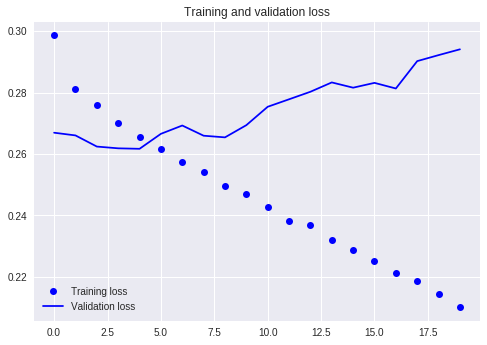

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32,
              dropout=0.2,
              recurrent_dropout=0.2,
              input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 661s 1s/step - loss: 0.3353 - val_loss: 0.2763
Epoch 2/40
500/500 [==============================] - 662s 1s/step - loss: 0.3123 - val_loss: 0.2732
Epoch 3/40
500/500 [==============================] - 659s 1s/step - loss: 0.3083 - val_loss: 0.2790
Epoch 4/40
500/500 [==============================] - 661s 1s/step - loss: 0.3013 - val_loss: 0.2695
Epoch 5/40
500/500 [==============================] - 660s 1s/step - loss: 0.2963 - val_loss: 0.2688
Epoch 6/40
500/500 [==============================] - 661s 1s/step - loss: 0.2951 - val_loss: 0.2651
Epoch 7/40
500/500 [==============================] - 660s 1s/step - loss: 0.2903 - val_loss: 0.2696
Epoch 8/40
500/500 [==============================] - 660s 1s/step - loss: 0.2872 - val_loss: 0.2697
Epoch 9/40
500/500 [==============================] - 660s 1s/step - loss: 0.2845 - val_loss: 0.2663
Epoch 10/40
500/500 [==============================] - 659s 1s/step - loss: 0.2828 - val_lo

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()